In [1]:
from tensorflow import keras
from pathlib import Path
import argparse
import yaml
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from utils.misc import triplet_to_str
from preprocessing.database import clean_database, download_database
from preprocessing.sets import preprocess_data
from knn.knn import Observations, KNN #visualisation_resultats

/home/schlegen/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/schlegen/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/schlegen/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/schlegen/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.

In [2]:
parser = argparse.ArgumentParser()
parser.add_argument('--config', help='Path to the config file', default='./default_config.yml')
parser.add_argument('--log-dir', help='Path to the log directory', default='../log/')
parser.add_argument('--posters', help='Path to the posters', default='../data/posters/')
parser.add_argument('--models-dir', help='Path to the saved models', default='../data/models/')
parser.add_argument('--sets-dir', help='Path to the training and testing sets', default='../data/sets/')
parser.add_argument('--database', help='Path to the databse csv', default='../data/poster_data.csv')
parser.add_argument('--csv', help='Path to the clean csv', default='../data/')
parser.add_argument('-s', '--save', help='Save model', action='store_true')
parser.add_argument('-v', '--verbose', help='Verbose', action='store_true')

str_args = '-v -s'.split()
args, _ = parser.parse_known_args(str_args)

logger = None

In [3]:
config = yaml.safe_load(open(args.config, encoding='utf-8'))

nb_genres = len(config["genres"])
input_size = config["image_size"]

In [4]:
appendix_split = 's{}t{}_'.format(
    config['size_per_genre'],
    config['testing_split']
) + triplet_to_str(config['image_size']) + '_' + str(nb_genres) + ".npy"

data_name = [Path(prefix+appendix_split) for prefix in
    [args.sets_dir + 'xtr_',
    args.sets_dir + 'ytr_',
    args.sets_dir + 'idtr_',
    args.sets_dir + 'xtest_',
    args.sets_dir + 'ytest_',
    args.sets_dir + 'idtest_']
]

In [5]:
data_name[0]

PosixPath('../data/sets/xtr_s700t0.15_100-100-3_7.npy')

In [6]:
selection_name = args.csv+'clean_poster_data_'+str(nb_genres)+'.csv'

if Path(selection_name).exists():
    if args.verbose:
        print('Database already cleaned')
    clean_movies = pd.read_csv(Path(selection_name))
else:
    clean_movies = clean_database(Path(args.database))
    if args.save:
        clean_movies.to_csv(Path(selection_name))

Database already cleaned


In [7]:
if data_name[0].exists() and data_name[1].exists() and data_name[2].exists() and data_name[3].exists() and data_name[4].exists() and data_name[5].exists():
    if args.verbose:
        print('Training and testing sets already made')
    train_posters, train_genres, train_ids = np.load(data_name[0]), np.load(data_name[1]), np.load(data_name[2])
    test_posters, test_genres, test_ids = np.load(data_name[3]), np.load(data_name[4]), np.load(data_name[5])

else:
    train_posters, train_genres, train_ids, test_posters, test_genres, test_ids = preprocess_data(
        clean_movies, config['genres'], config['size_per_genre'], args.posters, config['image_size'],
        config['seed'], testing_split=config['testing_split'], verbose=args.verbose, logger=logger
    )
    if args.save:
        sets_path = Path(args.sets_dir)
        if not sets_path.exists():
            sets_path.mkdir()
        np.save(data_name[0], train_posters)
        np.save(data_name[1], train_genres)
        np.save(data_name[2], train_ids)
        np.save(data_name[3], test_posters)
        np.save(data_name[4], test_genres)
        np.save(data_name[5], test_ids)

Training and testing sets already made


## Création des features 

### ResNet

In [8]:
resnet = keras.applications.resnet_v2.ResNet50V2(
    input_shape=input_size, include_top=False, weights="imagenet"
)

AttributeError: module 'tensorflow.python.keras.api._v1.keras.applications' has no attribute 'resnet_v2'

In [ ]:
train_features_resnet = resnet.predict(train_posters.astype(np.float32)).reshape(
    (len(train_posters), -1)
)
    
test_features_resnet = resnet.predict(test_posters.astype(np.float32)).reshape(
    (len(test_posters), -1)
)

### Histogrammes de couleurs

RGB

In [20]:
#Training sets
train_features_rgb_r = 
train_features_rgb_g= np.load('../data/features/histo_rgb_g_train.npy')
train_features_rgb_b = np.load('../data/features/histo_rgb_b_train.npy')
print('shape train rgb r', train_features_rgb_r.shape)
print('shape train rgb g', train_features_rgb_g.shape)
print('shape train rgb b', train_features_rgb_b.shape)

train_features_rgb = np.concatenate((train_features_rgb_r, train_features_rgb_g, train_features_rgb_b), axis=1)
print('Shape train rgb', train_features_rgb.shape)

#Testing sets
test_features_rgb_r = np.load('../data/features/histo_rgb_r_test.npy')
test_features_rgb_g = np.load('../data/features/histo_rgb_g_test.npy')
test_features_rgb_b = np.load('../data/features/histo_rgb_b_test.npy')
print('shape test rgb r', test_features_rgb_r.shape)
print('shape test rgb g', test_features_rgb_g.shape)
print('shape test rgb b', test_features_rgb_b.shape)

test_features_rgb = np.concatenate((test_features_rgb_r, test_features_rgb_g, test_features_rgb_b), axis=1)
print('Shape test rgb', test_features_rgb.shape)

shape train rgb r (4165, 256)
shape train rgb g (4165, 256)
shape train rgb b (4165, 256)
Shape train rgb (4165, 768)
shape test rgb r (734, 256)
shape test rgb g (734, 256)
shape test rgb b (734, 256)
Shape test rgb (734, 768)


LAB

In [30]:
# Training sets
train_features_lab_l = np.load('../data/features/histo_lab_l_train.npy')
train_features_lab_a= np.load('../data/features/histo_lab_a_train.npy')
train_features_lab_b = np.load('../data/features/histo_lab_b_train.npy')
print('shape train lab l', train_features_lab_l.shape)
print('shape train lab a', train_features_lab_a.shape)
print('shape train lab b', train_features_lab_b.shape)

train_features_lab = np.concatenate((train_features_lab_l, train_features_lab_a, train_features_lab_b), axis=1)

# Testing sets
test_features_lab_l = np.load('../data/features/histo_lab_l_test.npy')
test_features_lab_a = np.load('../data/features/histo_lab_a_test.npy')
test_features_lab_b = np.load('../data/features/histo_lab_b_test.npy')
print('shape test lab l', test_features_lab_l.shape)
print('shape test lab a', test_features_lab_a.shape)
print('shape test lab b', test_features_lab_b.shape)

test_features_lab = np.concatenate((test_features_lab_l, test_features_lab_a, test_features_lab_b), axis=1)

shape train lab l (4165, 256)
shape train lab a (4165, 256)
shape train lab b (4165, 256)
shape test lab l (734, 256)
shape test lab a (734, 256)
shape test lab b (734, 256)


Affichage des plus proches voisins sur un exemple

In [11]:
# TODO

Calcul des prédictions sur le testing set

In [33]:
k=3
predicted_genres = KNN(clean_movies, train_posters, train_features_lab, train_genres, train_ids, test_posters, test_features_lab, test_ids, -1, k, print_results=False)

Generating kNN Classifier...


  1%|▉                                                                | 10/734 [00:00<00:07, 90.82it/s]

kNN Classifier generated.


100%|███████████████████████████████████████████████████████████████| 734/734 [00:07<00:00, 103.08it/s]


genres ['Action', 'Animation', 'Comédie', 'Comédie dramatique', 'Documentaire', 'Drame', 'Thriller-Policier']
accuracy: 0.23024523160762944


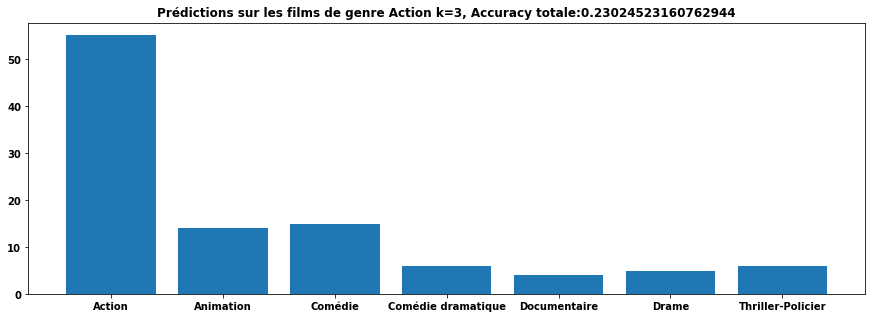

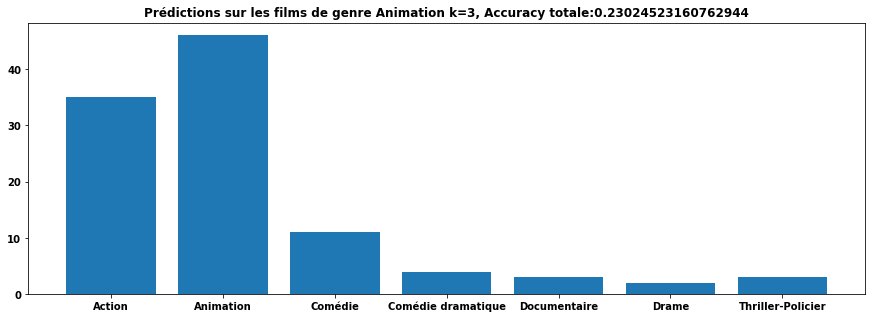

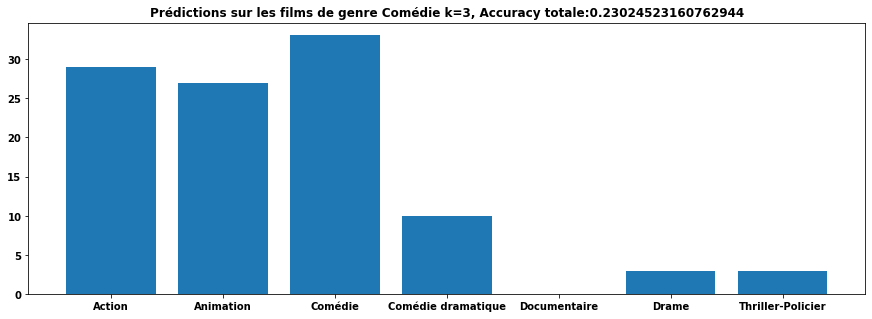

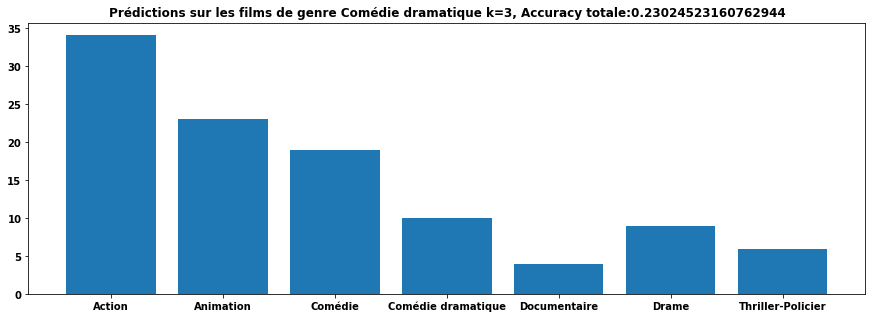

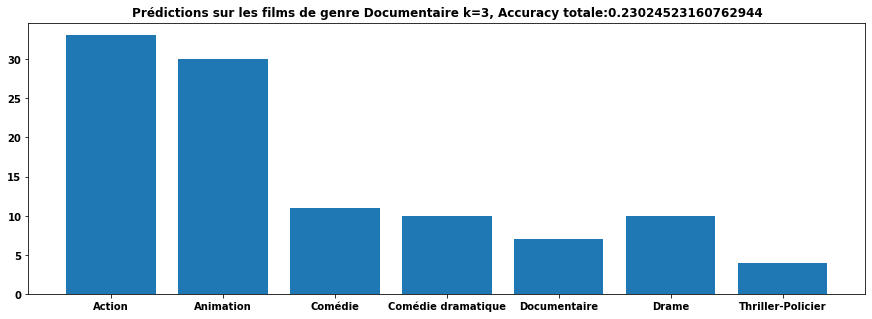

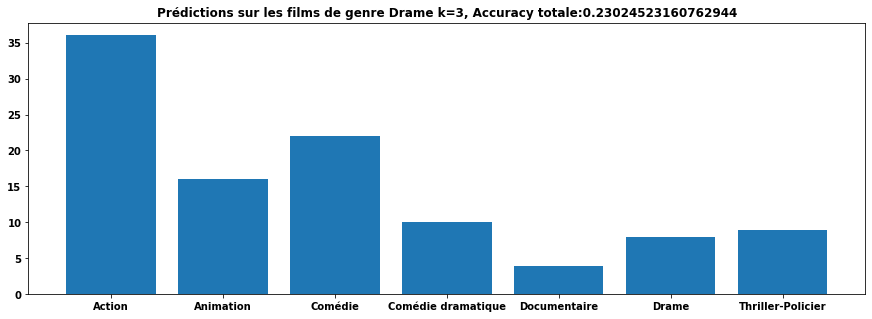

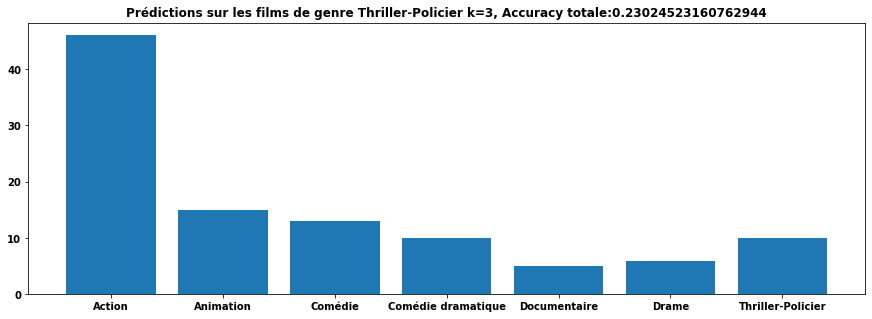

0.23024523160762944

In [34]:
genres_inv = {config['genres'][k]: k for k in config['genres'].keys()}
print('genres', list(config['genres']))

def visualisation_resultats(predicted_genres, test_genres, kneighbors, save=False):
    predictions = np.array([genres_inv[k] for k in np.argmax(predicted_genres, axis=1)])
    ground_truth = np.array([genres_inv[k] for k in np.argmax(test_genres, axis=1)])

    genres = config["genres"]
    # results_per_genre : matrice donc les lignes sont les vrais genres, et les colonnes sont les genres prédits
    results_per_genre = {
        genre_true : {genre_pred : 0 for genre_pred in genres}
        for genre_true in genres
    }
    #print("results per genre", results_per_genre)
    #print('results per genre ligne', results_per_genre['Action'].values())
    # total_per_genre : vecteur qui comptabilise le nombre de représentants de chaque genre
    total_per_genre = {
        genre : 0
        for genre in genres
    }
    # Mise à jour de results_per_genre et total_per_genre en fonction des prédictions
    n = len(predictions)
    for i in range(n):
        results_per_genre[ground_truth[i]][predictions[i]] += 1
        total_per_genre[ground_truth[i]] += 1

    # Accuracy
    accuracy = 0
    for genre in genres:
        accuracy += results_per_genre[genre][genre]
    accuracy /= len(test_posters)
    print('accuracy:', accuracy)

    # Visualisation:
    genres_list = list(config['genres'])
    for iterateur in genres_list:
        plt.figure(figsize=(15, 5))
        plt.title('Prédictions sur les films de genre ' + iterateur + ' k='+str(k) +", Accuracy totale:" + str(accuracy))
        plt.bar(genres_list, results_per_genre[iterateur].values())
        plt.show()
        if save:
            plt.savefig('../results/Resnet+kNN/'+iterateur+'_k='+str(kneighbors)+'.png')
    return(accuracy)

visualisation_resultats(predicted_genres, test_genres, k)

# Prédiction des genres:

## Creation des features

Les blocs suivant sert à "automatiser" la sélection des features :

In [26]:
# POUR LA METHODE RESNET :

RESNET = False #encore à faire

# POUR LES HISTOGRAMMES :

# On renseigne d'abord si on veut l'histogramme pour la couleur considérée, puis le nombre de bins
# Attention, les histogrammes avec le nombre de bins correspondants doivent avoir été calculés

RGB_R = False
RGB_R_bins = 256

RGB_G = False
RGB_G_bins = 256 

RGB_B = False
RGB_B_bins = 256 

LAB_L = True
LAB_L_bins = 16

LAB_A = True
LAB_A_bins = 16

LAB_B = True
LAB_B_bins = 16

Dans le bloc suivant, on définit le dictionnaire en fonction de nos choix de features :

In [36]:
obs_train = Observations(1) # 4 pour la distance
obs_test = Observations(1)

if RGB_R:
    obs_train.add_histo_feature(np.load('../data/features/histo_rgb_r_train_' + str(RGB_R_bins) + '.npy'))
    obs_test.add_histo_feature(np.load('../data/features/histo_rgb_r_test_' + str(RGB_R_bins) + '.npy'))

if RGB_G:
    obs_train.add_histo_feature(np.load('../data/features/histo_rgb_g_train_' + str(RGB_G_bins) + '.npy'))
    obs_test.add_histo_feature(np.load('../data/features/histo_rgb_g_test_' + str(RGB_G_bins) + '.npy'))

if RGB_B:
    obs_train.add_histo_feature(np.load('../data/features/histo_rgb_b_train_' + str(RGB_B_bins) + '.npy'))
    obs_test.add_histo_feature(np.load('../data/features/histo_rgb_b_test_' + str(RGB_B_bins) + '.npy'))
    
if LAB_L:
    obs_train.add_histo_feature(np.load('../data/features/histo_lab_l_train_' + str(LAB_L_bins) + '.npy'))
    obs_test.add_histo_feature(np.load('../data/features/histo_lab_l_test_' + str(LAB_L_bins) + '.npy'))
    
if LAB_A:
    obs_train.add_histo_feature(np.load('../data/features/histo_lab_a_train_' + str(LAB_A_bins) + '.npy'))
    obs_test.add_histo_feature(np.load('../data/features/histo_lab_a_test_' + str(LAB_A_bins) + '.npy'))
    
if LAB_B:
    obs_train.add_histo_feature(np.load('../data/features/histo_lab_b_train_' + str(LAB_B_bins) + '.npy'))
    obs_test.add_histo_feature(np.load('../data/features/histo_lab_b_test_' + str(LAB_B_bins) + '.npy'))

In [37]:
k=7
obs_train.compute_distance()

predicted_genres = KNN(
    dataset=clean_movies,
    Xtr=train_posters,
    tr_features=obs_train.observations,
    Ytr=train_genres,
    training_ids=train_ids,
    Xtest=test_posters,
    test_features=obs_test.observations,
    testing_ids=test_ids,
    ind=-1,
    k=k,
    metric=obs_train.distance,
    print_results=False
)

Generating kNN Classifier...


  1%|          | 6/733 [00:00<00:14, 48.81it/s]

kNN Classifier generated.


100%|██████████| 733/733 [00:11<00:00, 65.14it/s]


Visualisation des résultats

In [38]:
genres_inv = {config['genres'][k]: k for k in config['genres'].keys()}
print('genres', list(config['genres']))

def visualisation_resultats(predicted_genres, test_genres, kneighbors, save=False):
    predictions = np.array([genres_inv[k] for k in np.argmax(predicted_genres, axis=1)])
    ground_truth = np.array([genres_inv[k] for k in np.argmax(test_genres, axis=1)])

    genres = config["genres"]
    # results_per_genre : matrice donc les lignes sont les vrais genres, et les colonnes sont les genres prédits
    results_per_genre = {
        genre_true : {genre_pred : 0 for genre_pred in genres}
        for genre_true in genres
    }
    #print("results per genre", results_per_genre)
    #print('results per genre ligne', results_per_genre['Action'].values())
    # total_per_genre : vecteur qui comptabilise le nombre de représentants de chaque genre
    total_per_genre = {
        genre : 0
        for genre in genres
    }
    # Mise à jour de results_per_genre et total_per_genre en fonction des prédictions
    n = len(predictions)
    for i in range(n):
        results_per_genre[ground_truth[i]][predictions[i]] += 1
        total_per_genre[ground_truth[i]] += 1

    # Accuracy
    accuracy = 0
    for genre in genres:
        accuracy += results_per_genre[genre][genre]
    accuracy /= len(test_posters)
    print('accuracy:', accuracy)

    # Visualisation:
    genres_list = list(config['genres'])
    for iterateur in genres_list:
        plt.figure(figsize=(15, 5))
        plt.title('Prédictions sur les films de genre ' + iterateur + ' k='+str(k) +", Accuracy totale:" + str(accuracy))
        plt.bar(genres_list, results_per_genre[iterateur].values())
        plt.show()
        if save:
            plt.savefig('../results/Resnet+kNN/'+iterateur+'_k='+str(kneighbors)+'.png')
    return(accuracy)

genres ['Action', 'Animation', 'Comédie', 'Comédie dramatique', 'Documentaire', 'Drame', 'Thriller-Policier']


accuracy: 0.24556616643929058


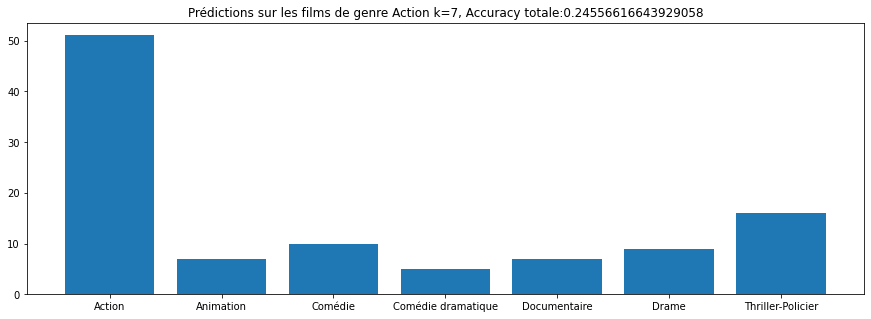

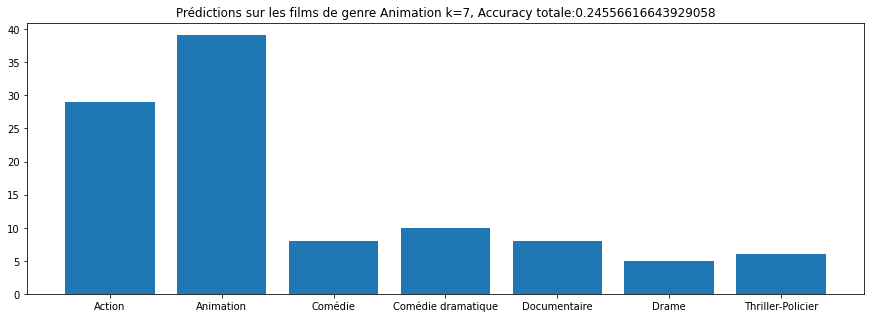

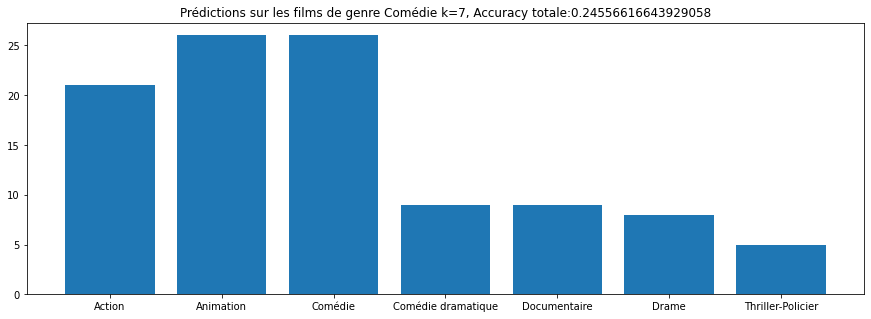

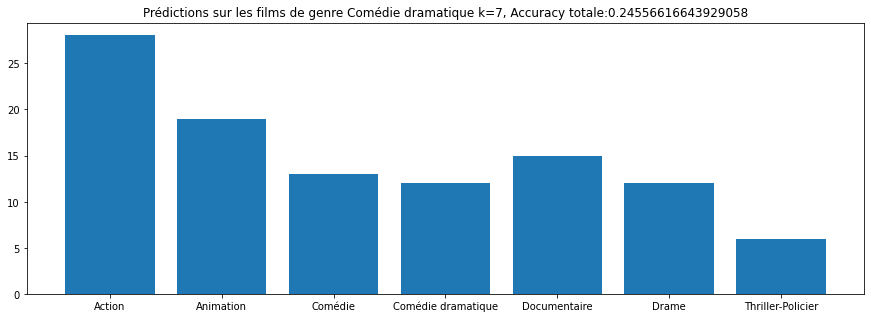

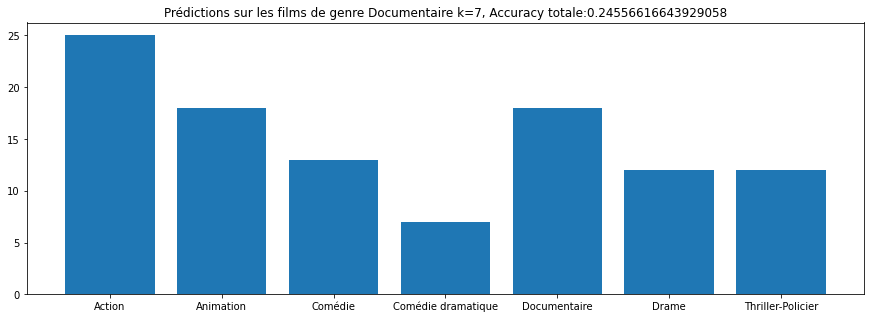

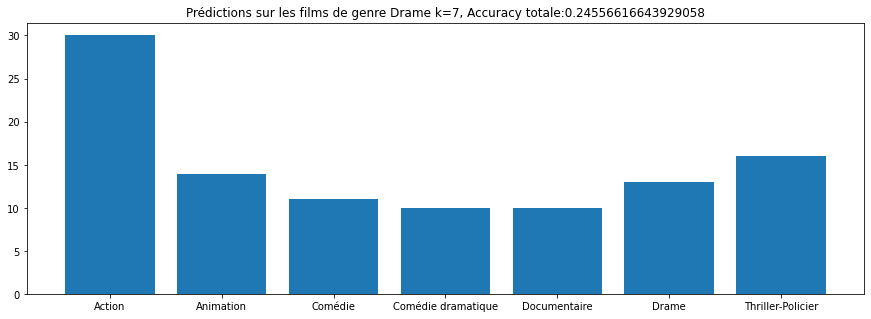

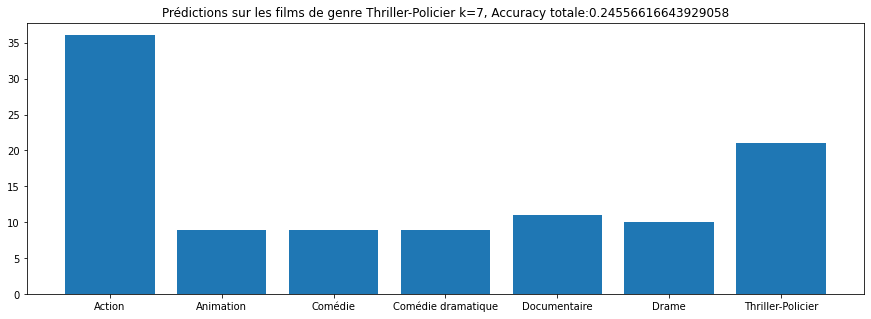

0.24556616643929058

In [39]:
visualisation_resultats(predicted_genres, test_genres, k)